In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import pandas as pd
from comparers import ModelComparer
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, get_pruned_trees, eval_diro2c, get_generated_data
from surrogate_tree import get_feature_importances, plot_feature_importances, plot_surrogate_tree,\
                           extract_rules, print_rules, plot_tree_leafs_for_class
from util import RuleClassifier, evaluate_counterfactual_fidelity, get_complexity, group_metrics
from tasks.boston_housing import make_task3 as make_task

In [2]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task()

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

In [5]:
def get_predicted_rules(indices=None):
    indices = y_true if indices is None else indices
    pred_node_ids = tree.apply(X[indices])
    node_id_to_rule_no = lambda node_id: np.where(node_ids == node_id)[0][0] + 1 if node_id in node_ids else None
    pred_rule_nos = [node_id_to_rule_no(pred_node_id) for pred_node_id in pred_node_ids]
    return pd.Series(pred_rule_nos, index=indices)

# Explanations

In [ ]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    explainer = WrappedDiro2C(X, comparer, class_name)
    explanation = explainer.generate_global_explanation()
    with open(f'explanations/diro2c.{class_name}.pickle', 'wb') as f:
        pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

This was run on a different machine (Intel(R) Xeon(R) CPU E5-2676 v3 @ 2.40GHz):
- (0, 0)... 0:09:14.121881
- (0, 1)... 0:18:27.296837
- (0, 2)... 0:27:39.069402
- (1, 0)... 0:36:50.820186
- (1, 1)... 0:46:05.013733
- (1, 2)... 0:55:17.436635
- (2, 0)... 1:04:28.611089
- (2, 1)... 1:13:41.226071
- (2, 2)... 1:22:54.833047

## $(0,1)$

In [6]:
focus_class = '(0, 1)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [7]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [9]:
s = pd.Series(get_generated_data(explanation)[1]).value_counts()
s.sum(), s[1]

(34404, 14223)

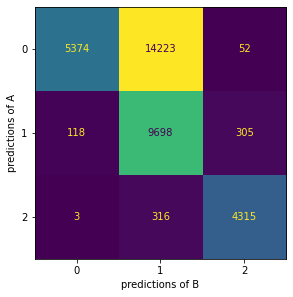

In [8]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/boston3-diro2c-cf-01.pdf')

In [9]:
%%time
trees = get_pruned_trees(explanation)
with open(f'explanations/diro2c.{focus_class}.tree.pickle', 'wb') as f:
    pickle.dump(trees, f)

CPU times: user 2min 58s, sys: 2.45 s, total: 3min
Wall time: 3min 23s


653

In [10]:
with open(f'explanations/diro2c.{focus_class}.tree.pickle', 'rb') as f:
    trees = pickle.load(f)
tree_it = iter(trees)
len(trees)

653

In [11]:
trees[-1].get_depth()

31

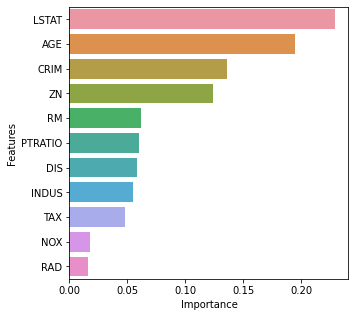

In [12]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

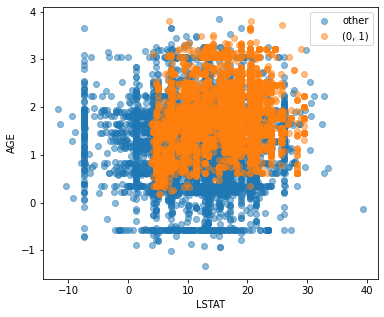

In [8]:
plot_diro2c_2d(explanation, 'LSTAT', 'AGE', class_names=class_names)

### 2 Leafs

In [12]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.044378366605484054, 1, 2)

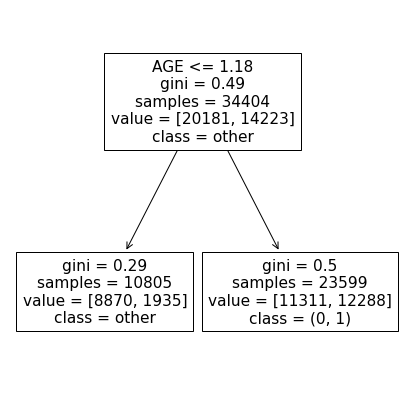

In [13]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [14]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. AGE > 1 => (0, 1) [11311, 12288]


### 3 Leafs

In [15]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.01675494340039045, 2, 3)

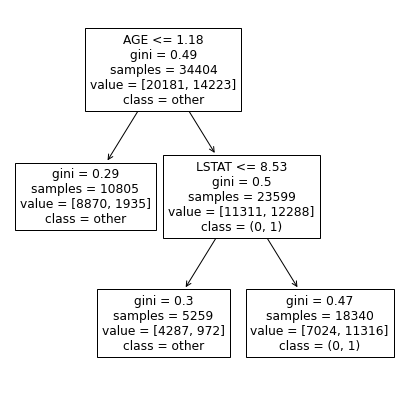

In [16]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [17]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. LSTAT > 8.53 and AGE > 1 => (0, 1) [7024, 11316]


### 5 Leafs

In [18]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.015781829512449996, 4, 5)

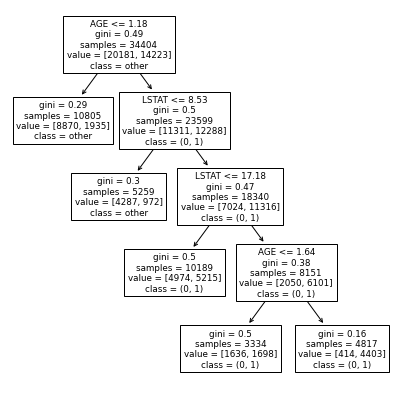

In [19]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [20]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. 8.53 < LSTAT <= 17.18 and AGE > 1 => (0, 1) [4974, 5215]
2. LSTAT > 17.18 and AGE > 2 => (0, 1) [414, 4403]
3. LSTAT > 17.18 and 1 < AGE <= 2 => (0, 1) [1636, 1698]


### 6 Leafs

In [21]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.014269193938039867, 4, 6)

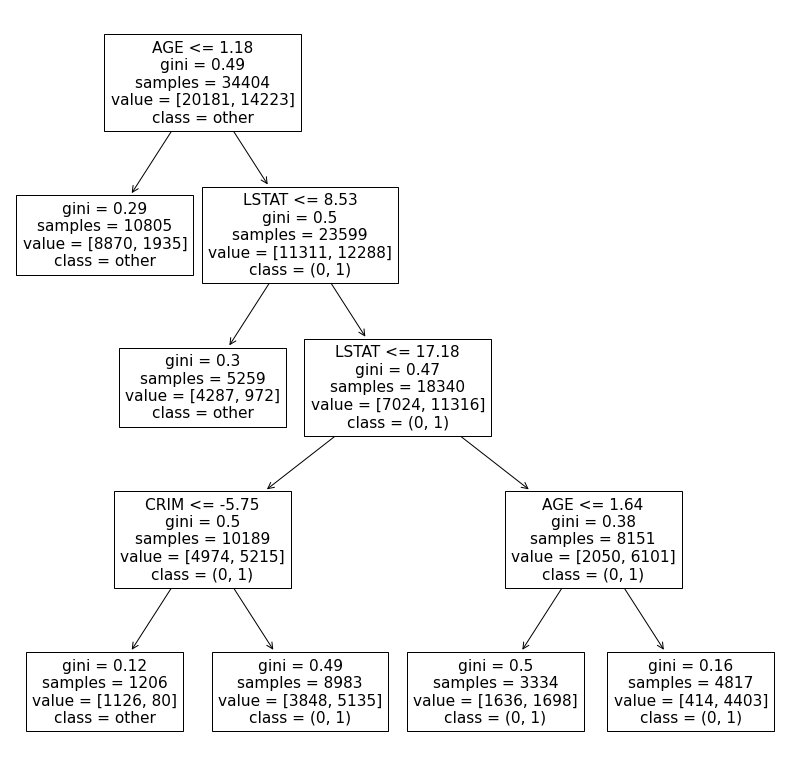

In [22]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [85]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. 8.53 < LSTAT <= 17.18 and AGE > 1 and CRIM > -5.7 => (0, 1) [3848, 5135]
2. LSTAT > 17.18 and AGE > 2 => (0, 1) [414, 4403]
3. LSTAT > 17.18 and 1 < AGE <= 2 => (0, 1) [1636, 1698]


In [88]:
get_predicted_rules()

8      1.0
28     1.0
40     1.0
42     2.0
74     2.0
151    1.0
152    1.0
157    2.0
180    2.0
196    1.0
238    NaN
244    2.0
245    2.0
dtype: float64

This does not explain instance \#238. But there is no explanation at all for it.

In [77]:
indices = [238]
for level, tree in enumerate(trees):
    constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
    pred_node_ids = tree.apply(X[indices])
    node_id_to_rule_no = lambda node_id: np.where(node_ids == node_id)[0][0] + 1 if node_id in node_ids else None
    pred_rule_nos = [node_id_to_rule_no(pred_node_id) for pred_node_id in pred_node_ids]
    if all([no != None for no in pred_rule_nos]):
        print(level)
        break

## $(1,0)$

In [9]:
focus_class = '(1, 0)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [10]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [91]:
s = pd.Series(get_generated_data(explanation)[1]).value_counts()
s.sum(), s[1]

(24810, 3011)

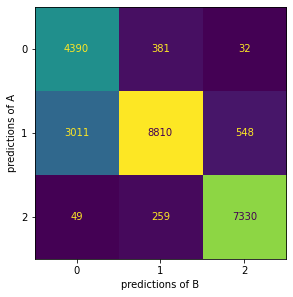

In [92]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/boston3-diro2c-cf-10.pdf')

In [93]:
%%time
trees = get_pruned_trees(explanation)
with open(f'explanations/diro2c.{focus_class}.tree.pickle', 'wb') as f:
    pickle.dump(trees, f)

CPU times: user 11.4 s, sys: 193 ms, total: 11.6 s
Wall time: 15.4 s


In [94]:
with open(f'explanations/diro2c.{focus_class}.tree.pickle', 'rb') as f:
    trees = pickle.load(f)
tree_it = iter(trees)
len(trees)

92

In [95]:
trees[-1].get_depth()

28

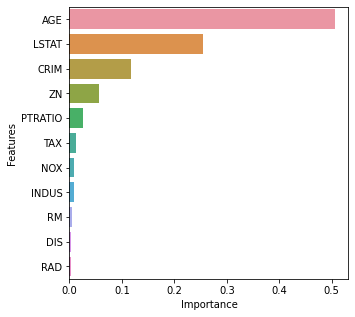

In [96]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

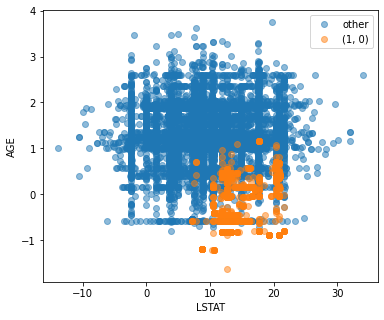

In [11]:
plot_diro2c_2d(explanation, 'LSTAT', 'AGE', class_names=class_names)

### 2 Leafs

In [30]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.03780738821535676, 1, 2)

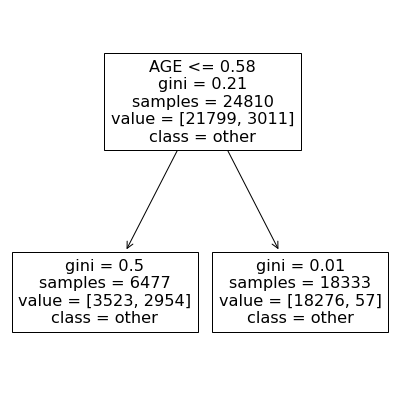

In [31]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [32]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

### 3 Leafs

In [33]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.02347633831479074, 2, 3)

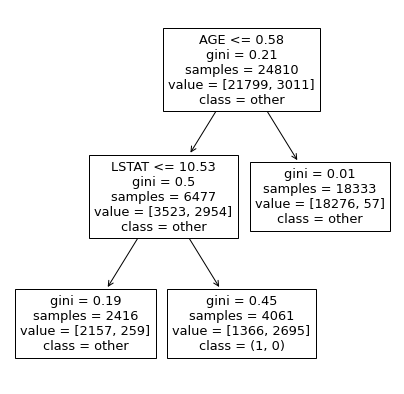

In [34]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [100]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. AGE <= 1 and LSTAT > 10.53 => (1, 0) [1366, 2695]


## $(1,2)$

In [12]:
focus_class = '(1, 2)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [13]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [104]:
s = pd.Series(get_generated_data(explanation)[1]).value_counts()
round(s[1] / s.sum() * 100)

36

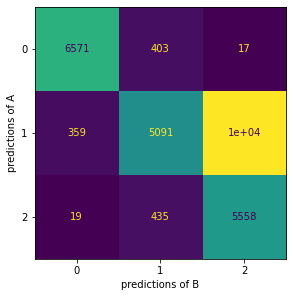

In [105]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/boston3-diro2c-cf-12.pdf')

In [106]:
%%time
trees = get_pruned_trees(explanation)
with open(f'explanations/diro2c.{focus_class}.tree.pickle', 'wb') as f:
    pickle.dump(trees, f)

CPU times: user 57.8 s, sys: 797 ms, total: 58.6 s
Wall time: 1min 11s


In [107]:
with open(f'explanations/diro2c.{focus_class}.tree.pickle', 'rb') as f:
    trees = pickle.load(f)
tree_it = iter(trees)
len(trees)

302

In [108]:
trees[-1].get_depth()

32

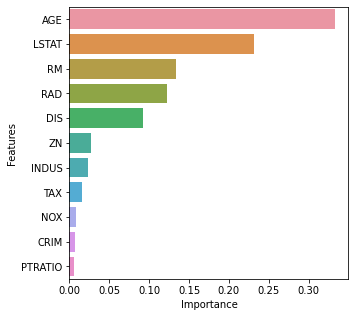

In [109]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

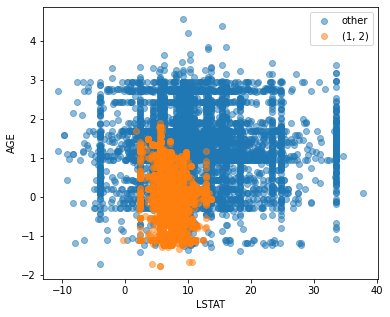

In [14]:
plot_diro2c_2d(explanation, 'LSTAT', 'AGE', class_names=class_names)

### 2 Leafs

In [48]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.030941635049819644, 1, 2)

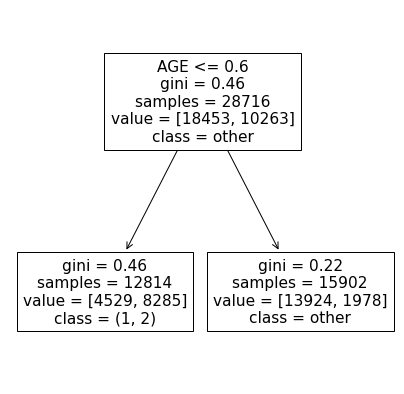

In [49]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [50]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. AGE <= 1 => (1, 2) [4529, 8285]


### 5 Leafs

In [51]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.030466524102793414, 3, 5)

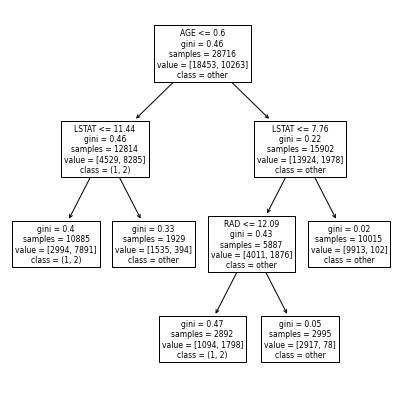

In [52]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [111]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. AGE <= 1 and LSTAT <= 11.44 => (1, 2) [2994, 7891]
2. AGE > 1 and LSTAT <= 7.76 and RAD <= 12.09 => (1, 2) [1094, 1798]


In [112]:
get_predicted_rules()

51    1
dtype: int64

## $(2,1)$

In [15]:
focus_class = '(2, 1)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [16]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

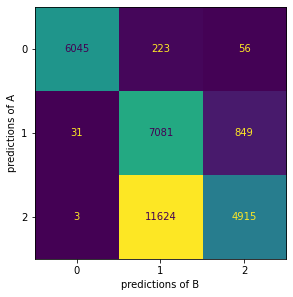

In [115]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/boston3-diro2c-cf-21.pdf')

In [116]:
%%time
trees = get_pruned_trees(explanation)
with open(f'explanations/diro2c.{focus_class}.tree.pickle', 'wb') as f:
    pickle.dump(trees, f)

CPU times: user 1min 39s, sys: 1.55 s, total: 1min 41s
Wall time: 2min 4s


In [117]:
with open(f'explanations/diro2c.{focus_class}.tree.pickle', 'rb') as f:
    trees = pickle.load(f)
tree_it = iter(trees)
len(trees)

417

In [118]:
trees[-1].get_depth()

39

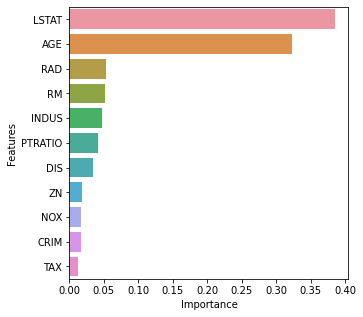

In [119]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

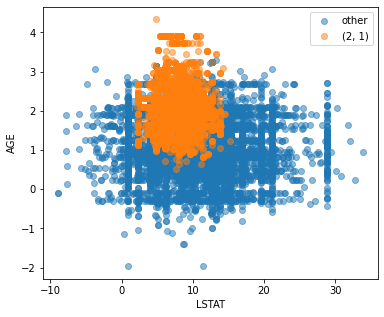

In [17]:
plot_diro2c_2d(explanation, 'LSTAT', 'AGE', class_names=class_names)

### 2 Leafs

In [72]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0885841446472844, 1, 2)

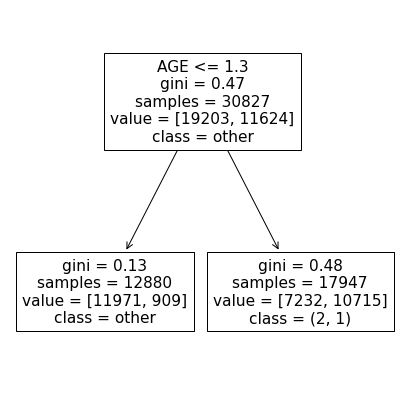

In [73]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [74]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. AGE > 1 => (2, 1) [7232, 10715]


### 3 Leafs

In [75]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.030886947219099264, 2, 3)

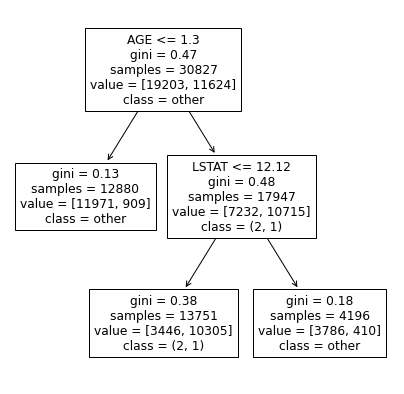

In [76]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [77]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. LSTAT <= 12.12 and AGE > 1 => (2, 1) [3446, 10305]


### 4 Leafs

In [78]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.014983075509264102, 3, 4)

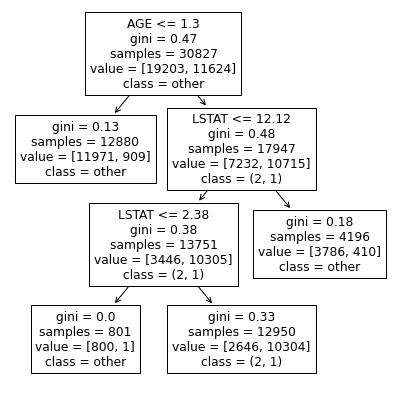

In [79]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [80]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. 2.38 < LSTAT <= 12.12 and AGE > 1 => (2, 1) [2646, 10304]


### 5 Leafs

In [81]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.013982447142295313, 4, 5)

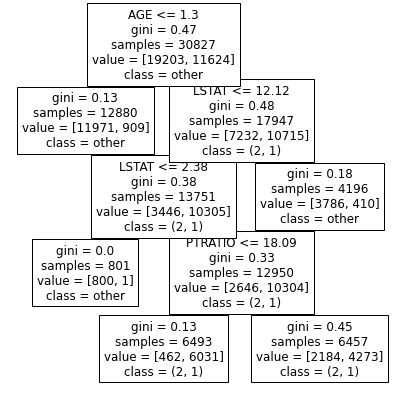

In [82]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [83]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. 2.38 < LSTAT <= 12.12 and AGE > 1 and PTRATIO <= 18.09 => (2, 1) [462, 6031]
2. 2.38 < LSTAT <= 12.12 and AGE > 1 and PTRATIO > 18.09 => (2, 1) [2184, 4273]


### 7 Leafs

In [84]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.008039953885020015, 4, 7)

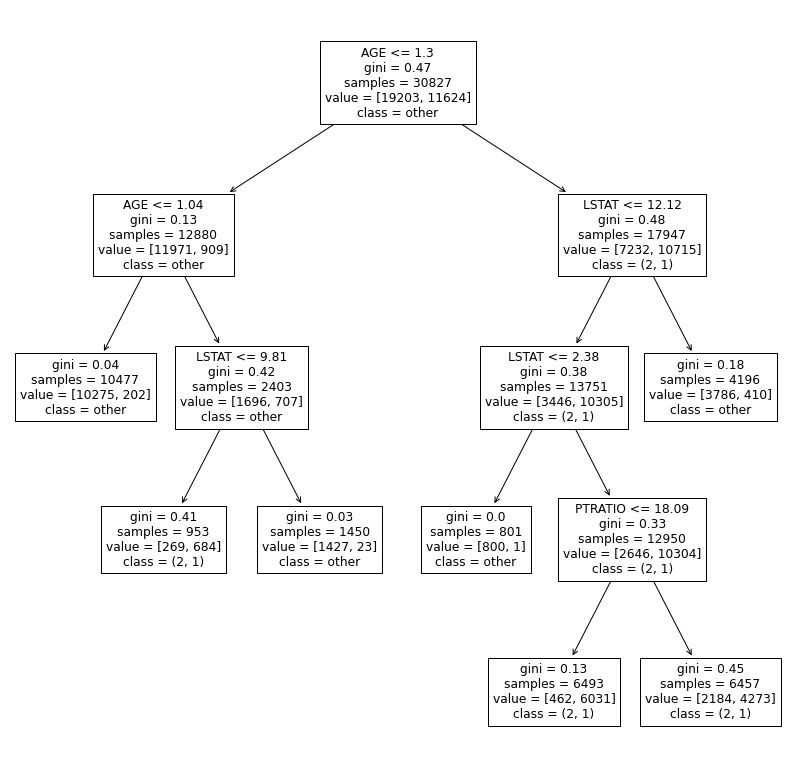

In [85]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [121]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. 2.38 < LSTAT <= 12.12 and AGE > 1 and PTRATIO <= 18.09 => (2, 1) [462, 6031]
2. 2.38 < LSTAT <= 12.12 and AGE > 1 and PTRATIO > 18.09 => (2, 1) [2184, 4273]
3. LSTAT <= 9.81 and 1 < AGE <= 1 => (2, 1) [269, 684]


In [122]:
get_predicted_rules()

34     2.0
77     NaN
101    2.0
dtype: float64

In [123]:
indices = [77]
for level, tree in enumerate(trees):
    constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
    pred_node_ids = tree.apply(X[indices])
    node_id_to_rule_no = lambda node_id: np.where(node_ids == node_id)[0][0] + 1 if node_id in node_ids else None
    pred_rule_nos = [node_id_to_rule_no(pred_node_id) for pred_node_id in pred_node_ids]
    if all([no != None for no in pred_rule_nos]):
        print(level)
        break

# Additional Material

In [60]:
from diro2c_wrapper import get_surrogate_tree

In [173]:
feature_importances_per_class = {}
for label, ax in zip(['(0, 1)', '(1, 0)', '(1, 2)', '(2, 1)'], axs.flat):
    with open(f'explanations/diro2c.{label}.pickle', 'rb') as f:
        explanation = pickle.load(f)
    tree = get_surrogate_tree(explanation)
    feature_importances_per_class[label] = tree.feature_importances_

In [174]:
s = pd.concat([pd.Series(a, index=feature_names) for a in feature_importances_per_class.values()],
              keys=feature_importances_per_class.keys(), names=['Class', 'Feature'])
df = pd.DataFrame(s, columns=['Feature Importance']).reset_index()

In [184]:
s = df.groupby('Feature').mean()['Feature Importance']
order = s.sort_values(ascending=False).index

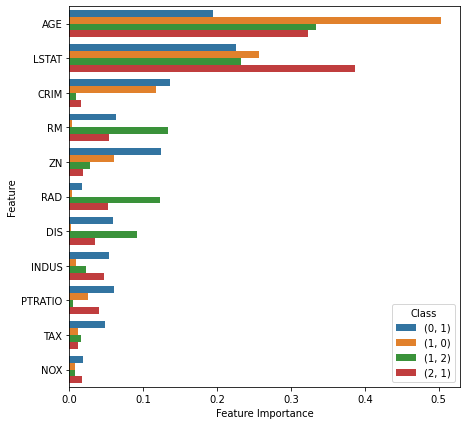

In [186]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(data=df, y='Feature', x='Feature Importance', hue='Class', order=order, ax=ax)
plt.savefig('figures/boston3-diro2c-featimp.pdf', bbox_inches='tight')

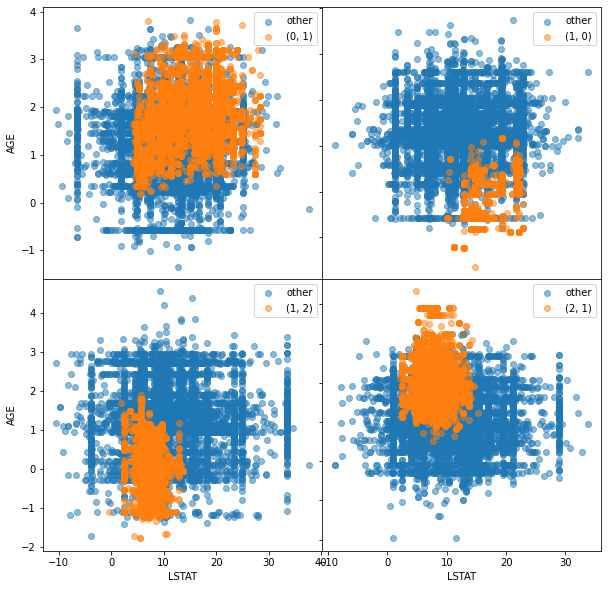

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
for label, ax in zip(['(0, 1)', '(1, 0)', '(1, 2)', '(2, 1)'], axs.flat):
    with open(f'explanations/diro2c.{label}.pickle', 'rb') as f:
        explanation = pickle.load(f)
    plot_diro2c_2d(explanation, 'LSTAT', 'AGE', ax=ax, class_names=['other', label])
    if label in ['(1, 0)', '(2, 1)']:
        ax.set_yticklabels([])
        ax.set_ylabel('')
plt.subplots_adjust(wspace=.0, hspace=0)
plt.savefig('figures/boston3-diro2c-scatter.png', bbox_inches='tight')

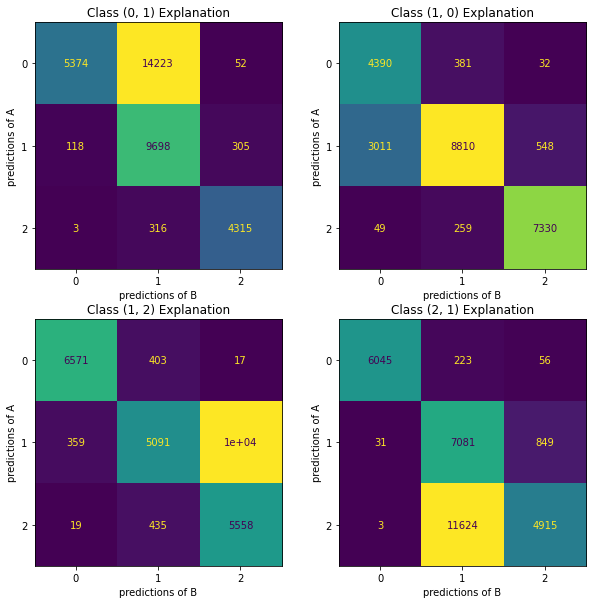

In [8]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
for label, ax in zip(['(0, 1)', '(1, 0)', '(1, 2)', '(2, 1)'], axs.flat):
    with open(f'explanations/diro2c.{label}.pickle', 'rb') as f:
        explanation = pickle.load(f)
    comparer.plot_confusion_matrix(get_generated_data(explanation)[0], ax=ax)
    ax.set_title(f'Class {label} Explanation')
plt.savefig('figures/boston3-diro2c-cm.pdf', bbox_inches='tight')

In [12]:
from util import get_complexity

In [14]:
n_constraints = 0
for label, n_leafs in [
    ('(0, 1)', 6),
    ('(1, 0)', 3),
    ('(1, 2)', 5),
    ('(2, 1)', 7)
]:
    with open(f'explanations/diro2c.{label}.pickle', 'rb') as f:
        explanation = pickle.load(f)
    trees = get_pruned_trees(explanation)
    _, feature_order = get_feature_importances(trees[-1])
    tree = [tree for tree in trees if tree.get_n_leaves() == n_leafs][0]
    constraints, rules, class_occurences, labels, rule_order =\
        extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions, latex=True)
    for rule in rules:
        print(f'\item if ${rule}$, then ${label}$')
    n_constraints += get_complexity(constraints)[1]
print(n_constraints)

\item if $8.53 < \text{LSTAT} \leq 17.18 \land \text{AGE} > 1 \land \text{CRIM} > -5.7$, then $(0, 1)$
\item if $\text{LSTAT} > 17.18 \land \text{AGE} > 2$, then $(0, 1)$
\item if $\text{LSTAT} > 17.18 \land 1 < \text{AGE} \leq 2$, then $(0, 1)$
\item if $\text{AGE} \leq 1 \land \text{LSTAT} > 10.53$, then $(1, 0)$
\item if $\text{AGE} \leq 1 \land \text{LSTAT} \leq 11.44$, then $(1, 2)$
\item if $\text{AGE} > 1 \land \text{LSTAT} \leq 7.76 \land \text{RAD} \leq 12.09$, then $(1, 2)$
\item if $2.38 < \text{LSTAT} \leq 12.12 \land \text{AGE} > 1 \land \text{PTRATIO} \leq 18.09$, then $(2, 1)$
\item if $2.38 < \text{LSTAT} \leq 12.12 \land \text{AGE} > 1 \land \text{PTRATIO} > 18.09$, then $(2, 1)$
\item if $\text{LSTAT} \leq 9.81 \land 1 < \text{AGE} \leq 1$, then $(2, 1)$
27
